In [14]:
import os
os.chdir(os.path.expanduser("~/Dev/uni/tsx/"))
os.getcwd()

'/home/lam/Dev/uni/tsx'

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries

DATA_DIR = "tests/data"

## Prepare Data Set

In [16]:
def load_data_set_bejin():
    data_link = f"{DATA_DIR}/pollution.csv"
    df = pd.read_csv(data_link)

    # Set date-time as index
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

    return df

## LIME for Time Series

### Load data

In [20]:
# Prepare data set
df = load_data_set_bejin()

# Encoding wind_direction to integer
encoder = LabelEncoder()
df["wind_direction"] = encoder.fit_transform(df["wind_direction"])

# Normalization
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(df[independents].values)
y_scaler.fit(df[dependent].values.reshape(-1, 1))



MinMaxScaler()

### Predict Function or explaining models

In [21]:
# Prepare predict function
wavenet = tf.keras.models.load_model(f"{DATA_DIR}/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"{DATA_DIR}/lstm_mts_128_1.h5")

def predict_fn(z, model=lstm):
    z = z.reshape(1, 128, 7)
    z_hat = model.predict(z)
    z_hat = y_scaler.inverse_transform(z_hat.reshape(-1, 1))  # to avoid zero coef_ for z_hat in[0, 1]
    z_hat = z_hat.ravel()
    return z_hat[0]

### LIME for a time series X

In [22]:
# 1- Load an instance
idx = 100
x = df[idx:idx + 128].copy()
x[independents] = x_scaler.transform(x[independents].values)
ts_x = x[independents].values.reshape(7, 128)

# 2- Choose XAI model
#   Here - with LIME for Time Series (Perturbation)
#       - XAI estimator in default is Lasso(alpha=0.5)
ts_lime = LIMETimeSeries(window_size=4, sample_size=100)
ts_lime.explain(ts_x, predict_fn=predict_fn)
# Todo - Multi run and average the coefficients


## Visualization

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

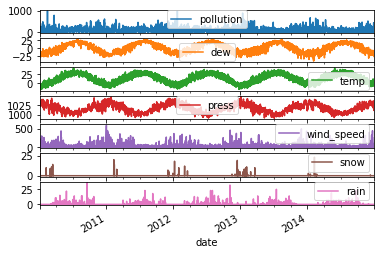

In [23]:

# 3- Visualization

# 3-1 Data
df.loc[:, df.columns != 'wind_direction'].plot(subplots=True)


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

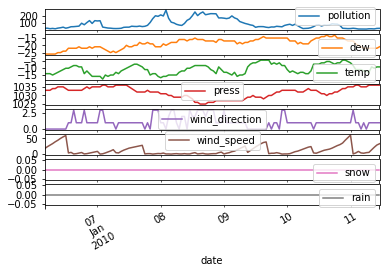

In [25]:

# 3-3 Training + Results (Optional)

# 3-2 Predictions vs Actual
#   Todo: Extend to interactive + windows selective (steps)

# 3-3 An instance x
x = df[idx:idx + 128].copy()
x.plot(subplots=True)

In [ ]:
# 3-4 A perturbed z_prime
#   Todo: a progress of randomly selecting z_prime

# 3-5 A perturbed z
#   Todo: a progress of randomly selecting z_prime

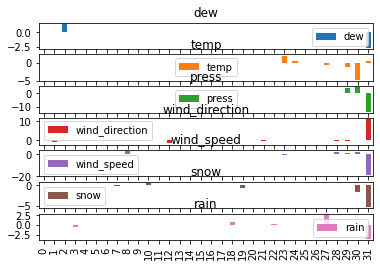

In [26]:
# 3-6 XAI Coefficient
#   Todo: Extend to interactive + windows selective (steps + w_size)
from sklearn.preprocessing import Normalizer
ts_lime.plot_coef(feature_names=independents)


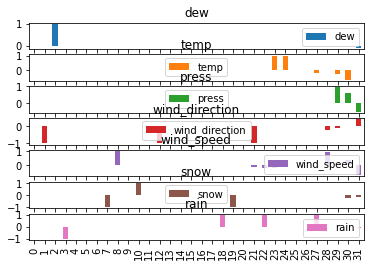

In [27]:
# 3-6b Alternative with scaled importance.
ts_lime.plot_coef(feature_names=independents, scaler=Normalizer())